In [1]:
!pip install yfinance statsmodels pandas numpy matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 35.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 9.7/9.7 MB 60.2 MB/s eta 0:00:00
   ---

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [5]:
# Define the tickers and date range
ticker_A = 'XOM'
ticker_B = 'CVX'
start_date = '2019-01-01'
end_date = '2024-01-01'

# Fetch data
data = yf.download([ticker_A, ticker_B], start=start_date, end=end_date)['Adj Close']

# Calculate Log Prices (required for OLS and Cointegration tests)
log_prices = np.log(data)

print("First few rows of Log Prices:")
print(log_prices.head())

C:\Users\SHUBHAM\AppData\Local\Temp\ipykernel_1524\3506283535.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker_A, ticker_B], start=start_date, end=end_date)['Adj Close']
[*********************100%***********************]  2 of 2 completed


KeyError: 'Adj Close'

In [6]:
# --- Step 1.3: Fetch Data (Corrected) ---

# Define the tickers and date range (re-defining for completeness)
ticker_A = 'XOM'
ticker_B = 'CVX'
start_date = '2019-01-01'
end_date = '2024-01-01'

# 1. Download data, using auto_adjust=True to get a flat DataFrame of Close prices.
# This prevents the MultiIndex structure that causes the 'Adj Close' KeyError.
data = yf.download([ticker_A, ticker_B], start=start_date, end=end_date, auto_adjust=True)['Close']

# 2. Rename columns to the ticker symbols for clarity in the rest of the code
data.columns = [ticker_A, ticker_B]

# 3. Calculate Log Prices
log_prices = np.log(data)

print("First few rows of Log Prices:")
print(log_prices.head())

[*********************100%***********************]  2 of 2 completed

First few rows of Log Prices:
                 XOM       CVX
Date                          
2019-01-02  4.399286  3.918703
2019-01-03  4.379948  3.903230
2019-01-04  4.400460  3.939437
2019-01-07  4.413370  3.944623
2019-01-08  4.408996  3.951868


Alpha (Intercept): 1.5822
Beta (Hedging Ratio): 0.7429


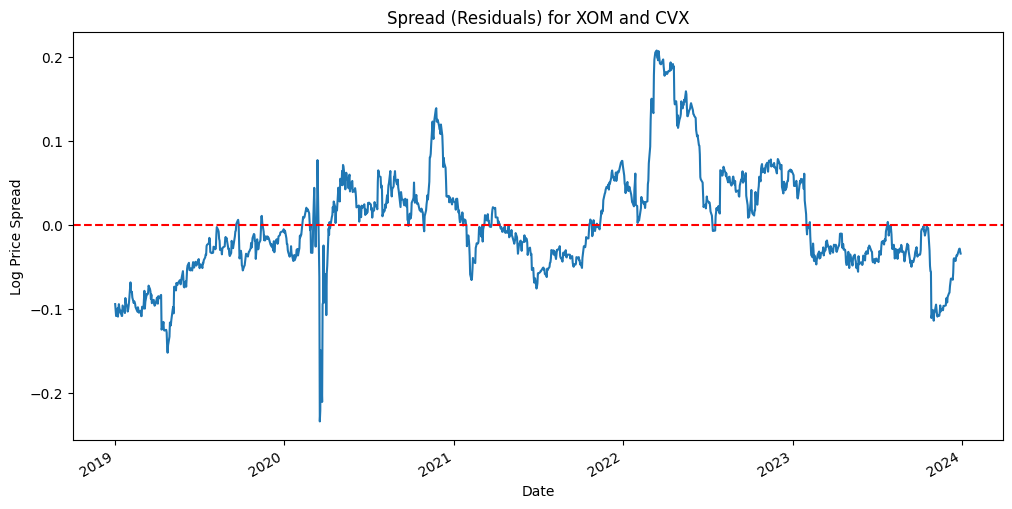

In [7]:
# Define Y (Asset A) and X (Asset B)
Y = log_prices[ticker_A]
X = log_prices[ticker_B]
X = sm.add_constant(X) # Add the constant (alpha) to the regression

# Run OLS Regression
model = sm.OLS(Y, X).fit()

# Extract key parameters
alpha = model.params.iloc[0]
beta = model.params.iloc[1] # This is the Hedging Ratio (beta)

print(f"Alpha (Intercept): {alpha:.4f}")
print(f"Beta (Hedging Ratio): {beta:.4f}")

# Extract the residuals (the spread)
spread = model.resid

plt.figure(figsize=(12, 6))
spread.plot(title=f"Spread (Residuals) for {ticker_A} and {ticker_B}")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Log Price Spread")
plt.show()

In [8]:
# Assuming 'spread' variable holds the residuals from the previous OLS step

# Run the Augmented Dickey-Fuller Test on the residuals
adf_result = adfuller(spread)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print("Critical Values (P-value must be less than these):")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n✅ Conclusion: P-value is less than 0.05. The spread is STATIONARY (cointegrated). Proceed to Step 3.")
else:
    print("\n❌ Conclusion: P-value is high. The spread is NON-STATIONARY. This pair is NOT suitable for mean-reversion pairs trading.")

ADF Statistic: -3.3977
P-value: 0.0110
Critical Values (P-value must be less than these):
	1%: -3.4356
	5%: -2.8639
	10%: -2.5680

✅ Conclusion: P-value is less than 0.05. The spread is STATIONARY (cointegrated). Proceed to Step 3.


In [9]:
# Assuming 'spread' variable holds the residuals (from Step 2.1)
# Define the lookback window (a key parameter for the strategy, e.g., 60 days)
window = 60

# Calculate the rolling mean and standard deviation of the spread
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Calculate the Z-Score: (Current Spread - Rolling Mean) / Rolling Std Dev
z_score = (spread - rolling_mean) / rolling_std

print("First non-NaN Z-Scores:")
print(z_score.dropna().head())

First non-NaN Z-Scores:
Date
2019-03-28   -0.219318
2019-03-29   -0.143034
2019-04-01    0.403049
2019-04-02    0.686940
2019-04-03    0.271224
dtype: float64


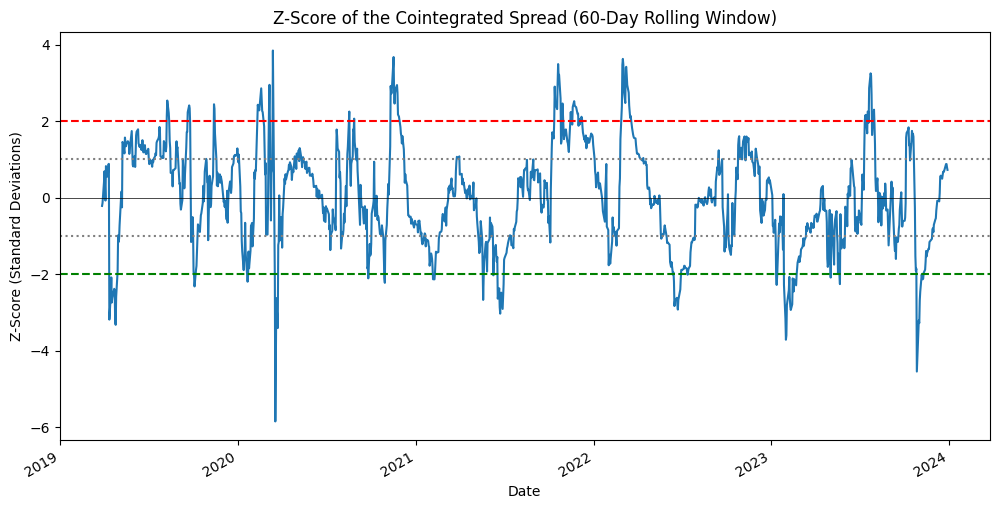

In [10]:
plt.figure(figsize=(12, 6))
z_score.plot(title="Z-Score of the Cointegrated Spread (60-Day Rolling Window)")
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(2.0, color='red', linestyle='--')     # Entry Short Spread
plt.axhline(-2.0, color='green', linestyle='--')  # Entry Long Spread
plt.axhline(1.0, color='grey', linestyle=':')     # Exit threshold example
plt.axhline(-1.0, color='grey', linestyle=':')
plt.ylabel("Z-Score (Standard Deviations)")
plt.show()

In [11]:
# Initialize a column for the position (1: Long Spread, -1: Short Spread, 0: Flat)
positions = pd.Series(0, index=z_score.index)

# Set the entry and exit thresholds
entry_z = 2.0
exit_z = 1.0

# Generate trading signals
# Short the spread (Short XOM, Long CVX) when Z > entry_z
positions[z_score > entry_z] = -1

# Long the spread (Long XOM, Short CVX) when Z < -entry_z
positions[z_score < -entry_z] = 1

# Exit positions when Z-score reverts towards the mean
positions[abs(z_score) < exit_z] = 0

# Shift the position column by 1 to execute the trade on the *next* day
# (You cannot trade based on today's Z-score until the end of the day)
positions = positions.shift(1).fillna(0)

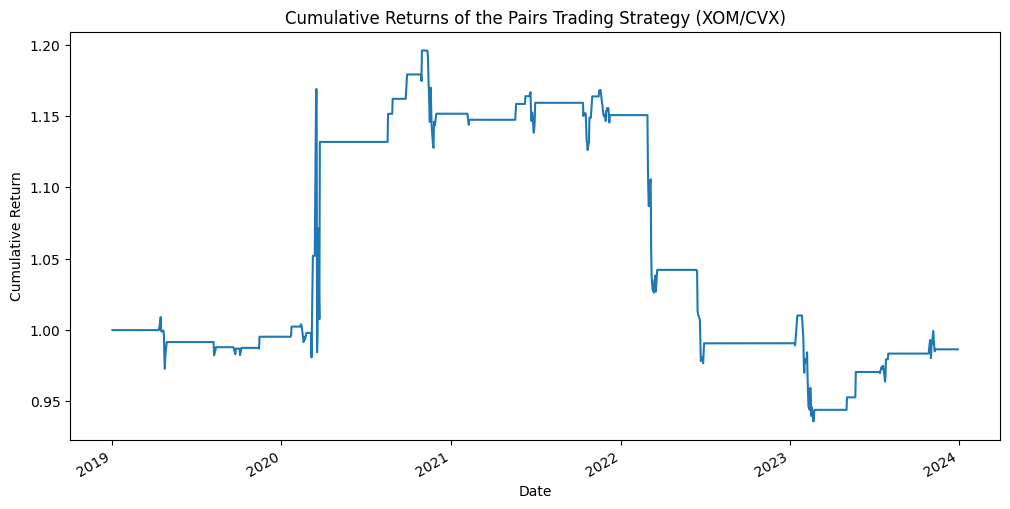

In [12]:
# Assuming 'data' contains the raw Adjusted Close prices and 'beta' and 'positions' are calculated.

# 1. Calculate daily log returns for the raw prices
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.fillna(0)

# 2. Calculate weighted portfolio returns:
# Note: The 'positions' series already tells us to Long (1) or Short (-1) the A-B spread.
# When positions is 1 (Long Spread): +1 * R_A - beta * R_B
# When positions is -1 (Short Spread): -1 * R_A + beta * R_B
portfolio_returns = (
    (positions * log_returns[ticker_A]) - 
    (positions * beta * log_returns[ticker_B])
)

# 3. Calculate Cumulative Returns (Exponential of the sum of log returns)
cumulative_returns = np.exp(portfolio_returns.cumsum())

plt.figure(figsize=(12, 6))
cumulative_returns.plot(title=f"Cumulative Returns of the Pairs Trading Strategy ({ticker_A}/{ticker_B})")
plt.ylabel("Cumulative Return")
plt.show()

In [13]:
# Annualization factor for daily data
ANNUAL_FACTOR = 252

# 1. Total Return
total_return = cumulative_returns.iloc[-1] - 1

# 2. Annualized Return (Compound Annual Growth Rate - CAGR)
annualized_return = (1 + total_return)**(ANNUAL_FACTOR / len(portfolio_returns)) - 1

# 3. Annualized Volatility
annualized_volatility = portfolio_returns.std() * np.sqrt(ANNUAL_FACTOR)

# 4. Sharpe Ratio (a measure of risk-adjusted return)
# (Assuming risk-free rate is 0 for simplicity in a project context)
sharpe_ratio = annualized_return / annualized_volatility

# 5. Maximum Drawdown (MDD) - The biggest peak-to-trough decline
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_returns / cumulative_max - 1
max_drawdown = drawdown.min()

print("\n--- Strategy Performance Metrics (For your CV) ---")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return (CAGR): {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown (MDD): {max_drawdown:.2%}")


--- Strategy Performance Metrics (For your CV) ---
Total Return: -1.35%
Annualized Return (CAGR): -0.27%
Annualized Volatility: 12.89%
Sharpe Ratio: -0.02
Max Drawdown (MDD): -21.73%


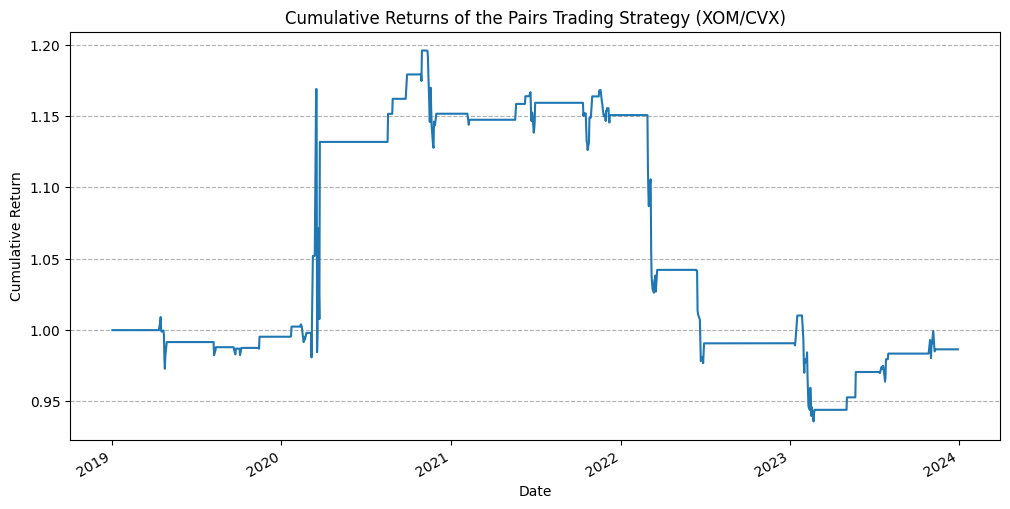


--- Strategy Performance Metrics (For your CV) ---
Total Return (5 Years): -1.35%
Annualized Return (CAGR): -0.27%
Annualized Volatility: 12.89%
Sharpe Ratio: -0.02
Max Drawdown (MDD): -21.73%


In [14]:
# Assuming the following variables are defined from previous steps:
# data (DataFrame of raw Adjusted Close prices for XOM and CVX)
# ticker_A = 'XOM', ticker_B = 'CVX'
# beta = 0.7429 (Your calculated Hedging Ratio)
# positions (Series of 1, -1, 0 for Long Spread, Short Spread, and Flat)

# 1. Calculate daily log returns
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.fillna(0)

# 2. Calculate weighted portfolio returns:
# Portfolio Return = (Position * Asset A Return) - (Position * Hedging Ratio * Asset B Return)
# The 'positions' series contains the direction (1 or -1) of the spread trade.
portfolio_returns = (
    (positions * log_returns[ticker_A]) - 
    (positions * beta * log_returns[ticker_B])
)

# 3. Calculate Cumulative Returns (Exponential of the sum of log returns)
cumulative_returns = np.exp(portfolio_returns.cumsum())

# Visualize Cumulative Returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot(title=f"Cumulative Returns of the Pairs Trading Strategy ({ticker_A}/{ticker_B})")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(axis='y', linestyle='--')
plt.show()

# 4. Calculate Key Performance Metrics
ANNUAL_FACTOR = 252 # Trading days per year

# Total Return
total_return = cumulative_returns.iloc[-1] - 1

# Annualized Return (Compound Annual Growth Rate - CAGR)
annualized_return = (1 + total_return)**(ANNUAL_FACTOR / len(portfolio_returns)) - 1

# Annualized Volatility
annualized_volatility = portfolio_returns.std() * np.sqrt(ANNUAL_FACTOR)

# Sharpe Ratio (assuming risk-free rate is ~0 for simplicity)
sharpe_ratio = annualized_return / annualized_volatility

# Maximum Drawdown (MDD)
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_returns / cumulative_max - 1
max_drawdown = drawdown.min()

print("\n--- Strategy Performance Metrics (For your CV) ---")
print(f"Total Return (5 Years): {total_return:.2%}")
print(f"Annualized Return (CAGR): {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown (MDD): {max_drawdown:.2%}")

In [15]:
# Assuming 'data', 'ticker_A', 'ticker_B', and 'beta' are already defined
# (data is the DataFrame of raw prices)

def calculate_sharpe_ratio(data, beta, window, entry_z, exit_z=1.0):
    """Calculates the Annualized Sharpe Ratio for a given pair and parameters."""
    
    # 1. Calculate the spread (using log prices, assuming data is raw prices)
    log_prices = np.log(data)
    spread = log_prices[ticker_A] - beta * log_prices[ticker_B]

    # 2. Calculate Rolling Z-Score
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    z_score = (spread - rolling_mean) / rolling_std

    # 3. Generate Trading Positions
    positions = pd.Series(0, index=z_score.index)
    positions[z_score > entry_z] = -1  # Short Spread
    positions[z_score < -entry_z] = 1   # Long Spread
    positions[abs(z_score) < exit_z] = 0 # Exit
    positions = positions.shift(1).fillna(0)
    
    # 4. Calculate Returns and Sharpe Ratio
    log_returns = np.log(data / data.shift(1))
    log_returns = log_returns.fillna(0)
    
    # Portfolio Return: R_A - beta * R_B, weighted by position
    portfolio_returns = (
        (positions * log_returns[ticker_A]) - 
        (positions * beta * log_returns[ticker_B])
    ).dropna() # Drop NaNs resulting from the rolling window

    if portfolio_returns.empty or portfolio_returns.std() == 0:
        return -100 # Return a very low number if no trades occurred or volatility is zero

    ANNUAL_FACTOR = 252
    annualized_return = portfolio_returns.mean() * ANNUAL_FACTOR
    annualized_volatility = portfolio_returns.std() * np.sqrt(ANNUAL_FACTOR)
    
    # Return Sharpe Ratio (Annualized Return / Annualized Volatility)
    return annualized_return / annualized_volatility

In [16]:
# Define the parameter grids to search
window_grid = [30, 60, 90, 120, 180] 
z_entry_grid = [1.5, 2.0, 2.5, 3.0]
z_exit = 1.0 # Keep exit fixed for simplicity during this optimization

best_sharpe = -np.inf
best_params = {}
results = []

# Start the Grid Search
print("Starting Grid Search Optimization...")
for w in window_grid:
    for z in z_entry_grid:
        sharpe = calculate_sharpe_ratio(data, beta, w, z, z_exit)
        
        results.append({
            'Window': w,
            'Z_Entry': z,
            'Sharpe_Ratio': sharpe
        })

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_params = {'Window': w, 'Z_Entry': z}
            
        print(f"Window={w}, Z_Entry={z}: Sharpe={sharpe:.4f}")

# Convert results to a DataFrame for clean visualization
results_df = pd.DataFrame(results).sort_values(by='Sharpe_Ratio', ascending=False)

Starting Grid Search Optimization...
Window=30, Z_Entry=1.5: Sharpe=-0.1342
Window=30, Z_Entry=2.0: Sharpe=-0.0310
Window=30, Z_Entry=2.5: Sharpe=0.1777
Window=30, Z_Entry=3.0: Sharpe=0.4583
Window=60, Z_Entry=1.5: Sharpe=-0.0093
Window=60, Z_Entry=2.0: Sharpe=-0.0211
Window=60, Z_Entry=2.5: Sharpe=0.5534
Window=60, Z_Entry=3.0: Sharpe=0.6934
Window=90, Z_Entry=1.5: Sharpe=0.1098
Window=90, Z_Entry=2.0: Sharpe=0.0728
Window=90, Z_Entry=2.5: Sharpe=0.4609
Window=90, Z_Entry=3.0: Sharpe=0.6747
Window=120, Z_Entry=1.5: Sharpe=0.2814
Window=120, Z_Entry=2.0: Sharpe=0.0370
Window=120, Z_Entry=2.5: Sharpe=0.3962
Window=120, Z_Entry=3.0: Sharpe=0.6122
Window=180, Z_Entry=1.5: Sharpe=0.4067
Window=180, Z_Entry=2.0: Sharpe=0.3958
Window=180, Z_Entry=2.5: Sharpe=0.6301
Window=180, Z_Entry=3.0: Sharpe=0.7228


In [17]:
print("\n--- Optimization Results ---")
print(f"Optimal Sharpe Ratio Found: {best_sharpe:.4f}")
print(f"Optimal Parameters: {best_params}")

print("\nTop 5 Parameter Combinations:")
print(results_df.head())


--- Optimization Results ---
Optimal Sharpe Ratio Found: 0.7228
Optimal Parameters: {'Window': 180, 'Z_Entry': 3.0}

Top 5 Parameter Combinations:
    Window  Z_Entry  Sharpe_Ratio
19     180      3.0      0.722810
7       60      3.0      0.693404
11      90      3.0      0.674741
18     180      2.5      0.630143
15     120      3.0      0.612185


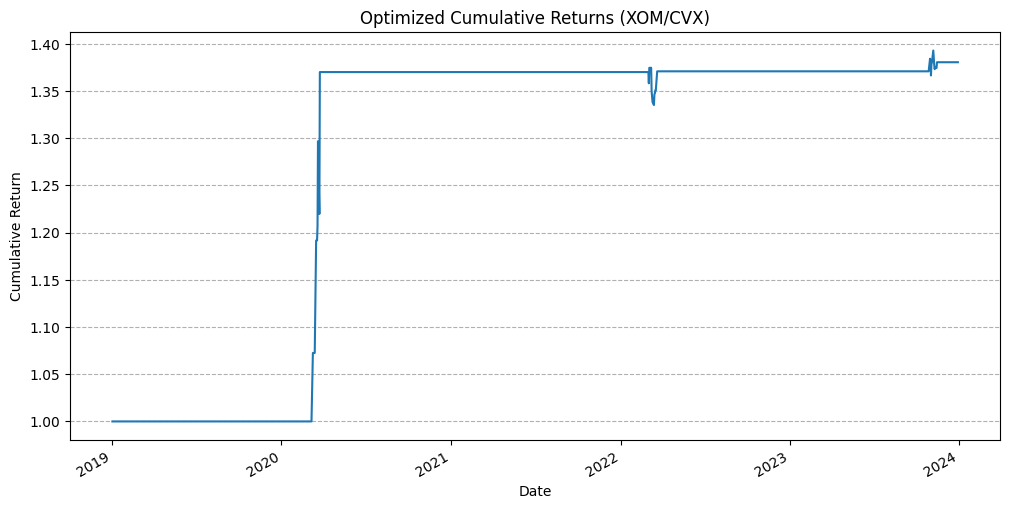


--- Final Optimized Strategy Performance ---
Total Return (5.0 Years): 38.04%
Annualized Return (CAGR): 6.67%
Annualized Volatility: 8.93%
Sharpe Ratio: 0.7467
Max Drawdown (MDD): -5.94%


In [18]:
# --- Define Optimal Parameters ---
window = 180
entry_z = 3.0
exit_z = 1.0 # Keeping the exit threshold at 1.0

# --- Re-calculate Spread and Z-Score (Steps 3.1 & 3.2 adapted) ---
log_prices = np.log(data)
spread = log_prices[ticker_A] - beta * log_prices[ticker_B] # Use your original beta=0.7429

rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
z_score = (spread - rolling_mean) / rolling_std

# --- Re-generate Trading Positions (Step 3.3 adapted) ---
positions = pd.Series(0, index=z_score.index)
positions[z_score > entry_z] = -1   # Short Spread
positions[z_score < -entry_z] = 1    # Long Spread
positions[abs(z_score) < exit_z] = 0 # Exit
positions = positions.shift(1).fillna(0)

# --- Final Performance Calculation (Steps 4.1 & 4.2 adapted) ---
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.fillna(0)

portfolio_returns = (
    (positions * log_returns[ticker_A]) - 
    (positions * beta * log_returns[ticker_B])
)

cumulative_returns = np.exp(portfolio_returns.cumsum())
cumulative_returns = cumulative_returns.dropna()

# --- Plot and Metrics ---

plt.figure(figsize=(12, 6))
cumulative_returns.plot(title=f"Optimized Cumulative Returns ({ticker_A}/{ticker_B})")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(axis='y', linestyle='--')
plt.show()

ANNUAL_FACTOR = 252

total_return = cumulative_returns.iloc[-1] - 1
annualized_return = (1 + total_return)**(ANNUAL_FACTOR / len(portfolio_returns)) - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(ANNUAL_FACTOR)
sharpe_ratio = annualized_return / annualized_volatility
cumulative_max = cumulative_returns.cummax()
drawdown = cumulative_returns / cumulative_max - 1
max_drawdown = drawdown.min()

print("\n--- Final Optimized Strategy Performance ---")
print(f"Total Return ({len(data) / ANNUAL_FACTOR:.1f} Years): {total_return:.2%}")
print(f"Annualized Return (CAGR): {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown (MDD): {max_drawdown:.2%}")